In [49]:
#### 1. h2o 분석 준비하기 ####
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import time
import h2o
from h2o.automl import H2OAutoML
from h2o.estimators.gbm import H2OGradientBoostingEstimator
%matplotlib inline

h2o.init()
h2o.no_progress()

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.20" 2023-07-18; OpenJDK Runtime Environment (build 11.0.20+8-post-Ubuntu-1ubuntu120.04); OpenJDK 64-Bit Server VM (build 11.0.20+8-post-Ubuntu-1ubuntu120.04, mixed mode, sharing)
  Starting server from /home/watercar99/.local/lib/python3.9/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmplrw2bf56
  JVM stdout: /tmp/tmplrw2bf56/h2o_watercar99_started_from_python.out
  JVM stderr: /tmp/tmplrw2bf56/h2o_watercar99_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Asia/Seoul
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.42.0.1
H2O_cluster_version_age:,2 months and 1 day
H2O_cluster_name:,H2O_from_python_watercar99_xhn8nb
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,29.97 Gb
H2O_cluster_total_cores:,36
H2O_cluster_allowed_cores:,36
H2O_cluster_status:,"locked, healthy"


In [50]:
# 데이터 불러오기
train_data = pd.read_csv("~/project/MIMIC-III/Baseline/overlap/OI/overlap_OI(50%)_train.csv")
test_data = pd.read_csv("~/project/MIMIC-III/Baseline/overlap/OI/overlap_OI(50%)_test.csv")

train_data.rename(columns={'HOSPITAL_EXPIRE_FLAG': 'y'}, inplace=True)
test_data.rename(columns={'HOSPITAL_EXPIRE_FLAG': 'y'}, inplace=True)

train_data.drop(["SUBJECT_ID","HADM_ID", "DOA", "TLOS", "ETHNICITY"], axis=1, inplace=True)
test_data.drop(["SUBJECT_ID","HADM_ID", "DOA", "TLOS", "ETHNICITY"], axis=1, inplace=True)

train_data = pd.get_dummies(train_data, columns=["GENDER"])
test_data = pd.get_dummies(test_data, columns=["GENDER"])

# train_data와 test_data의 칼럼을 맞추기 위해 차집합을 계산
missing_columns_in_test = set(train_data.columns) - set(test_data.columns)
missing_columns_in_train = set(test_data.columns) - set(train_data.columns)

# test_data에 train_data의 더미 변수를 추가하고 0으로 채워주기
for col in missing_columns_in_test:
    test_data[col] = 0

# train_data에 test_data의 더미 변수를 추가하고 0으로 채워주기
for col in missing_columns_in_train:
    train_data[col] = 0
    
####################################################################
# Down Sampling
# train 데이터의 레이블 비율 확인
train_labels = train_data['y']
label_counts = train_labels.value_counts()

# train 데이터의 레이블 비율이 1:1이 되도록 분할
class_0_data = train_data[train_data['y'] == 0]
class_1_data = train_data[train_data['y'] == 1]

# 레이블이 0인 데이터 중에서 샘플 개수가 적은 만큼만 선택
num_samples = min(label_counts[0], label_counts[1])
class_0_data = class_0_data.sample(num_samples, random_state=42)

# 레이블이 1인 데이터 중에서 샘플 개수가 적은 만큼만 선택
class_1_data = class_1_data.sample(num_samples, random_state=42)

# 선택한 데이터를 결합하여 최종 train 데이터 생성
train_data = pd.concat([class_0_data, class_1_data])
####################################################################

# train_data split
train_data, valid_data, _, _ = train_test_split(train_data, train_data['y'], test_size=0.2, random_state=42)

# 데이터 분할 결과 확인
print("Train Data:")
print(train_data['y'].value_counts())
print("Validation Data:")
print(valid_data['y'].value_counts())
print("Test Data:")
print(test_data['y'].value_counts())

Train Data:
1    1072
0    1057
Name: y, dtype: int64
Validation Data:
0    274
1    259
Name: y, dtype: int64
Test Data:
0    1304
1     614
Name: y, dtype: int64


In [51]:
y = "y"
x = list(train_data.columns)  #if x is defined as all columns except the response, then x is not required
x.remove(y)

h2o_train = h2o.H2OFrame(train_data)
h2o_valid = h2o.H2OFrame(valid_data)
h2o_test = h2o.H2OFrame(test_data)

# For binary classification, response should be a factor
h2o_train[y] = h2o_train[y].asfactor()
h2o_valid[y] = h2o_valid[y].asfactor()
h2o_test[y] = h2o_test[y].asfactor()

In [52]:
################################################################    
## Run AutoML for 120 seconds

aml = H2OAutoML(max_runtime_secs=120, exclude_algos =['StackedEnsemble'])
# aml = H2OAutoML(max_models=5, max_runtime_secs=100000, seed=1 ,include_algos=["gbm"])
aml.train(x = x, y = y, training_frame=h2o_train, leaderboard_frame=h2o_valid)

Model Details
=============
H2OXGBoostEstimator : XGBoost
Model Key: XGBoost_1_AutoML_1_20230822_162737


Model Summary: 
    number_of_trees
--  -----------------
    30

ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.08759335713794326
RMSE: 0.2959617494507411
LogLoss: 0.31168746396858493
Mean Per-Class Error: 0.09070041231872802
AUC: 0.9696898960730876
AUCPR: 0.9723406528917622
Gini: 0.9393797921461753

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4997142627835274
       0     1     Error    Rate
-----  ----  ----  -------  --------------
0      954   103   0.0974   (103.0/1057.0)
1      90    982   0.084    (90.0/1072.0)
Total  1044  1085  0.0907   (193.0/2129.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.499714     0.910524  194
max f2                       0.358363     0.932021  244
max f0point5                 0.61529      0.926471  156
max accuracy                 0.541113     0.910756  181
max precision                0.994432     1         0
max recall                   0.116263     1         350
max specificity              0.994432     1         0
max absolute_mcc             0.541113     0.822016  181
max min_per_class_accuracy   0.51233      0.907649  190
max mean_per_class_accuracy  0.541113     0.910871  181
max tns                      0.994432     1057      0
max fns                      0.994432     1071      0
max fps                      0.00650518   1057      399
max tps                      0.116263     1072      350
max tnr                      0.994432     1         0
max fnr                      0.994432     0.999067  0
max fpr                      0.00650518   1         399
max tpr                      0.116263     1         350

Gains/Lift Table: Avg response rate: 50.35 %, avg score: 50.52 %
group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain    kolmogorov_smirnov
-------  --------------------------  -----------------  ---------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------  --------------------
1        0.0103335                   0.964411           1.98601    1.98601            1                0.975701   1                           0.975701            0.0205224       0.0205224                  98.6007   98.6007            0.0205224
2        0.0201973                   0.956142           1.98601    1.98601            1                0.95996    1                           0.968014            0.0195896       0.0401119                  98.6007   98.6007            0.0401119
3        0.0300611                   0.948145           1.98601    1.98601            1                0.95154    1                           0.962608            0.0195896       0.0597015                  98.6007   98.6007            0.0597015
4        0.0403946                   0.940338           1.98601    1.98601            1                0.944441   1                           0.957961            0.0205224       0.0802239                  98.6007   98.6007            0.0802239
5        0.0502583                   0.934277           1.98601    1.98601            1                0.936977   1                           0.953843            0.0195896       0.0998134                  98.6007   98.6007            0.0998134
6        0.100047                    0.897565           1.98601    1.98601            1                0.916842   1                           0.935429            0.0988806       0.198694                   98.6007   98.6007            0.198694
7        0.150305                    0.864822           1.98601    1.98601        

In [53]:
lb = aml.leaderboard
lb.head(rows=lb.nrows)

model_id,auc,logloss,aucpr,mean_per_class_error,rmse,mse
XGBoost_1_AutoML_1_20230822_162737,0.735571,0.625226,0.705148,0.319921,0.461383,0.212874
GLM_1_AutoML_1_20230822_162737,0.73221,0.622312,0.684292,0.365569,0.459636,0.211265


In [54]:
performance = aml.leader.model_performance(h2o_valid)  # (Optional) Evaluate performance on a test set

model_id   =aml.leader.model_id  # 최고 모델 명
accuracy   =performance.accuracy()  # 정확도
precision  =performance.precision()  # precision
recall     =performance.recall()  # recall
F1         =performance.F1()  # f1
auc        =performance.auc()  # auc
variable_importance=aml.leader.varimp()  # 중요한 입력 변수

# print(model_id, accuracy, precision, recall, F1, auc, variable_importance)
# print(performance)

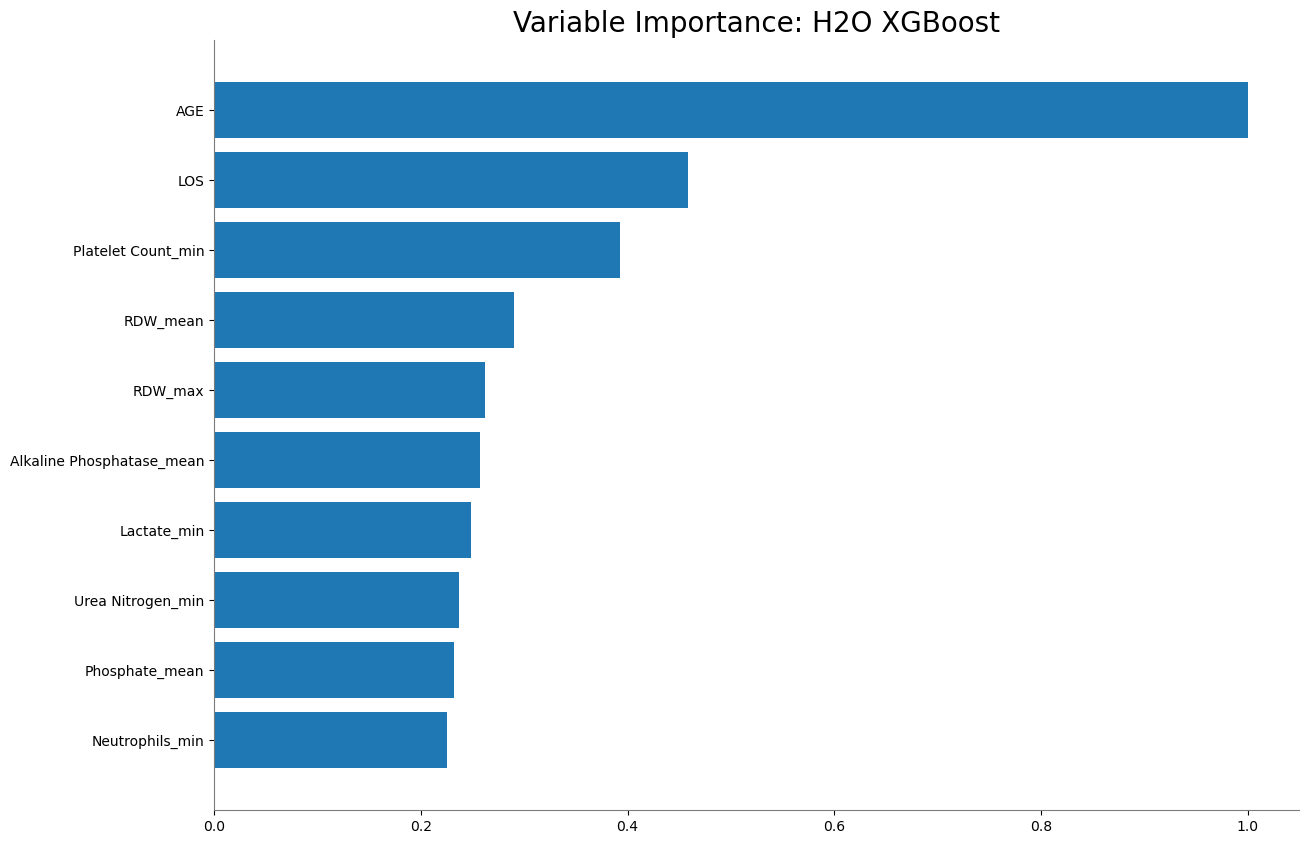

<Figure size 640x480 with 0 Axes>

In [55]:
## 중요 변수 시각화
aml.leader.varimp_plot()

### Test

In [56]:
aml.leader.model_performance(test_data=h2o_test)

ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.2329927784333741
RMSE: 0.48269325501126914
LogLoss: 0.6724393745216426
Mean Per-Class Error: 0.3606754960932036
AUC: 0.6972832277532423
AUCPR: 0.523168166998687
Gini: 0.3945664555064845

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4640408992767334
       0    1    Error    Rate
-----  ---  ---  -------  --------------
0      769  535  0.4103   (535.0/1304.0)
1      191  423  0.3111   (191.0/614.0)
Total  960  958  0.3785   (726.0/1918.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.464041     0.538168  208
max f2                       0.107283     0.713602  359
max f0point5                 0.748311     0.524523  90
max accuracy                 0.764876     0.715328  83
max precision                0.991426     1         0
max recall                   0.0194712    1         397
max specificity              0.991426     1         0
max absolute_mcc             0.61857      0.291809  142
max min_per_class_accuracy   0.514332     0.641694  187
max mean_per_class_accuracy  0.587903     0.649328  154
max tns                      0.991426     1304      0
max fns                      0.991426     613       0
max fps                      0.0103382    1304      399
max tps                      0.0194712    614       397
max tnr                      0.991426     1         0
max fnr                      0.991426     0.998371  0
max fpr                      0.0103382    1         399
max tpr                      0.0194712    1         397

Gains/Lift Table: Avg response rate: 32.01 %, avg score: 47.16 %
group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain    kolmogorov_smirnov
-------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------  --------------------
1        0.0104275                   0.967742           2.49902   2.49902            0.8              0.979309   0.8                         0.979309            0.0260586       0.0260586                  149.902   149.902            0.0229911
2        0.0203337                   0.946969           1.8085    2.16262            0.578947         0.958244   0.692308                    0.969047            0.0179153       0.0439739                  80.8503   116.262            0.0347715
3        0.0302398                   0.934895           2.13732   2.15433            0.684211         0.940749   0.689655                    0.959777            0.0211726       0.0651466                  113.732   115.433            0.0513429
4        0.040146                    0.921375           2.13732   2.15013            0.684211         0.927553   0.688312                    0.951826            0.0211726       0.0863192                  113.732   115.013            0.0679143
5        0.0500521                   0.908314           2.30173   2.18014            0.736842         0.915378   0.697917                    0.944612            0.0228013       0.109121                   130.173   118.014            0.0868813
6        0.100104                    0.85382            1.69205   1.93609            0.541667         0.876683   0.619792                    0.910648            0.0846906       0.193811                   69.2047   93.6092            0.137829
7        0.150156                    0.801539           1.69205   1.85474            0.541667         0.827271   0.59375                     0.882855            0.0846906       0.278502                   69.2047   85.4743            0.188778
8        0.200209                   

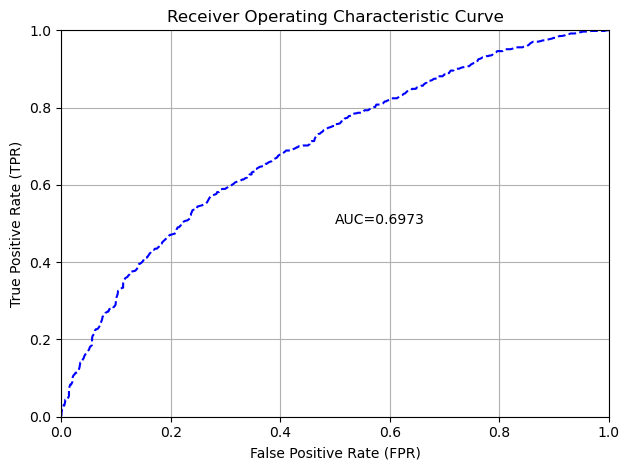

([0.0,
  0.0,
  0.0007668711656441718,
  0.0007668711656441718,
  0.0015337423312883436,
  0.003067484662576687,
  0.003834355828220859,
  0.003834355828220859,
  0.005368098159509203,
  0.006134969325153374,
  0.006901840490797546,
  0.006901840490797546,
  0.00843558282208589,
  0.010736196319018405,
  0.012269938650306749,
  0.013803680981595092,
  0.013803680981595092,
  0.013803680981595092,
  0.013803680981595092,
  0.014570552147239263,
  0.016104294478527608,
  0.01763803680981595,
  0.019938650306748466,
  0.019938650306748466,
  0.019938650306748466,
  0.020705521472392636,
  0.02223926380368098,
  0.023773006134969327,
  0.02607361963190184,
  0.027607361963190184,
  0.0299079754601227,
  0.03067484662576687,
  0.032208588957055216,
  0.032975460122699383,
  0.03374233128834356,
  0.03450920245398773,
  0.03680981595092025,
  0.037576687116564415,
  0.039110429447852764,
  0.040644171779141106,
  0.04217791411042945,
  0.046012269938650305,
  0.04831288343558282,
  0.0506134

In [57]:
%matplotlib inline
aml.leader.model_performance(test_data=h2o_test).plot()